In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [57]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.observations.ar_gaussian_observation import ARGaussianObservation
from ssm_ptc.transformations.linear import LinearTransformation
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import time

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

traj29 = rendered_data[29]

In [4]:
K = 5
D = 4
T = 36000

tran = LinearTransformation(K=K, D=D, lags=1)
observation = ARGaussianObservation(K=K, D=D, M=0, transformation=tran)

model = HMM(K=K, D=D, M=0, observation=observation)

data = torch.tensor(traj29, dtype=torch.float64)

In [5]:
model.log_likelihood(data)

tensor(-88714195.2949, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

In [6]:
num_iters = 5000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

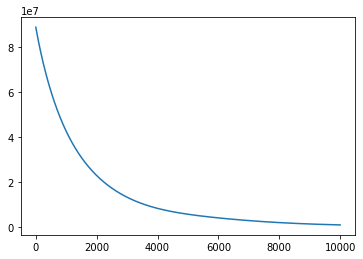

In [8]:
plt.plot(losses)

In [37]:
losses[-1]

array(935482.1439729)

In [9]:
z = model.most_likely_states(data)

In [10]:
sample_z, sample_x = model.sample(T)

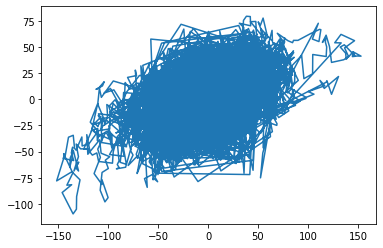

In [12]:
plt.plot(sample_x[:,0], sample_x[:,1])

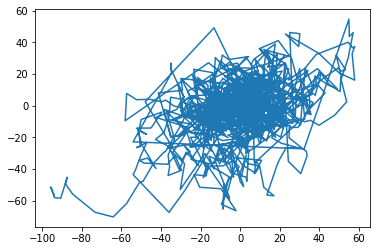

In [25]:
plt.plot(sample_x[:1000,2], sample_x[:1000,3])

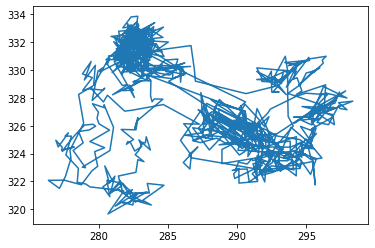

In [27]:
plt.plot(traj29[:1000,0], traj29[:1000,1])

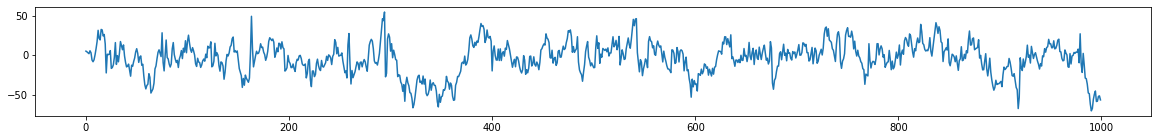

In [26]:
plt.figure(figsize=(20,2))
plt.plot(sample_x[:1000,3])

In [19]:
x_predict_arr = k_step_prediction(model, z, data)

In [20]:
x_predict_arr.shape

(36000, 4)

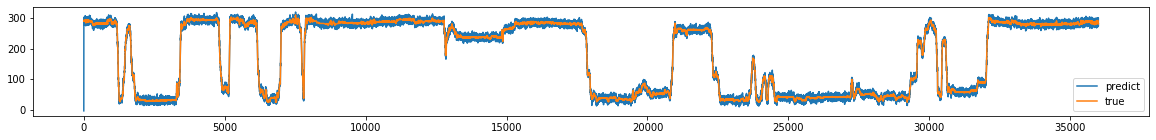

In [23]:
plt.figure(figsize=(20,2))
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()
plt.show()

# try ssm baseline

In [32]:
from ssm.hmm import HMM as ssm_hmm

In [162]:
arhmm = ssm_hmm(K, D, M=0, lags=100, observations="ar")

In [163]:
arhmm_lls = arhmm.fit(traj29, method='em', num_em_iters=50)

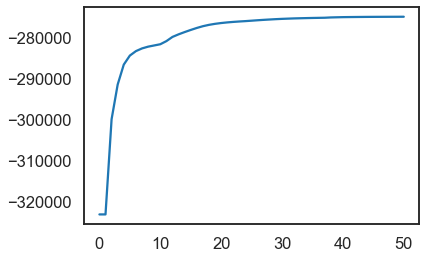

In [164]:
plt.plot(arhmm_lls)

In [165]:
z_1 = arhmm.most_likely_states(traj29)

([], <a list of 0 Text yticklabel objects>)

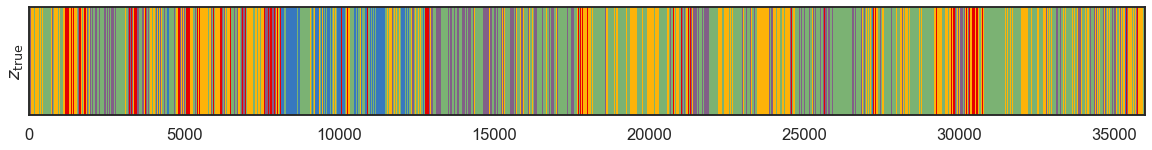

In [178]:
plt.figure(figsize=(20,2))
plt.imshow(z_1[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

In [157]:
arhmm_sample_z, arhmm_sample_x = arhmm.sample(T)

In [168]:
arhmm_sample_z_lags100, arhmm_sample_x_lags100 = arhmm.sample(T)

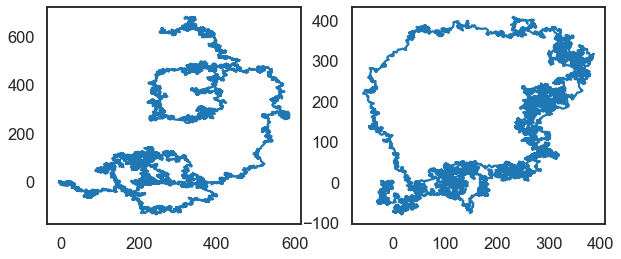

In [170]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(arhmm_sample_x_lags100[:,0], arhmm_sample_x_lags100[:,1])

plt.subplot(1,2,2)
plt.plot(arhmm_sample_x[:,0], arhmm_sample_x[:,1])  # lags = 10

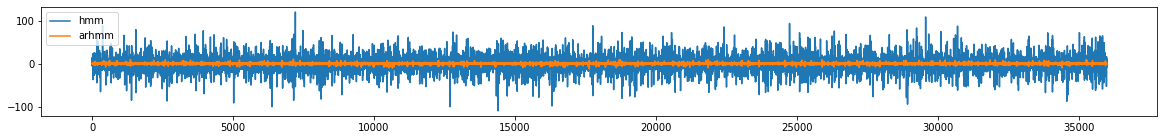

In [50]:
plt.figure(figsize=(20,2))
plt.plot(np.diff(sample_x[:,0]), label='hmm')
plt.plot(np.diff(arhmm_sample_x[:,0]), label='arhmm')
plt.legend()

In [ ]:
plt.figure(figsize=(20,2))
plt.plot(np.diff(sample_x[:,0]), label='hmm')
plt.plot(np.diff(arhmm_sample_x[:,0]), label='arhmm')
plt.legend()

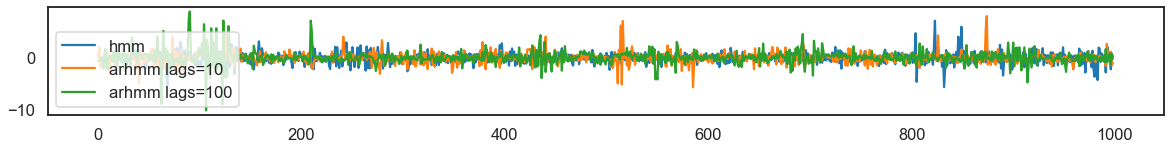

In [172]:
plt.figure(figsize=(20,2))
plt.plot(np.diff(traj29[:1000,0]), label='hmm')
plt.plot(np.diff(arhmm_sample_x[:1000,0]), label='arhmm lags=10')
plt.plot(np.diff(arhmm_sample_x_lags100[:1000,0]), label='arhmm lags=100')
plt.legend()

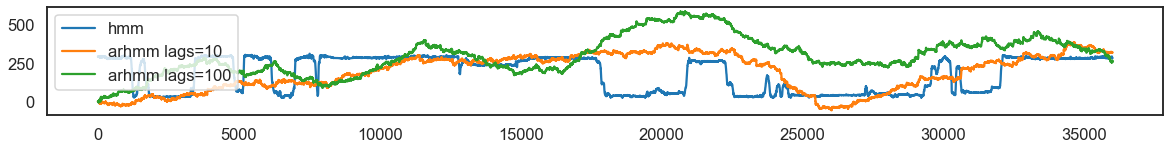

In [176]:
plt.figure(figsize=(20,2))
plt.plot(traj29[:,0], label='hmm')
plt.plot(arhmm_sample_x[:,0], label='arhmm lags=10')
plt.plot(arhmm_sample_x_lags100[:,0], label='arhmm lags=100')
plt.legend()

In [49]:
np.diff(sample_x[:,0])

array([ 5.99203182,  7.22115117, 12.94287301, ..., 11.09422659,
        3.49624464,  1.55834368])

- diagnose
    - check transition
    - check z

# try sgd on ssm_hmm

In [129]:
arhmm_2 = ssm_hmm(K, D, M=0, observations="ar")

In [130]:
arhmm_2.log_likelihood(traj29)

-31894313.754011746

In [131]:
arhmm_lls_2 = arhmm_2.fit(traj29, method='adam', num_iters=2000)

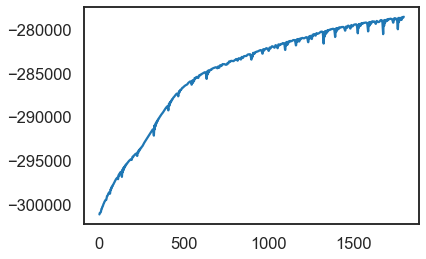

In [181]:
plt.plot(arhmm_lls_2[200:])

In [134]:
def arhmm_k_step_prediction(model, model_z, data, k=0):
    """
    Conditioned on the most likely hidden states, make the k-step prediction.
    """
    x_predict_arr = []
    input = np.zeros((data.shape[0],))
    if k == 0:
        for t in range(data.shape[0]):
            x_predict = model.observations.sample_x(model_z[t], data[:t], input)
            x_predict_arr.append(x_predict)
    else:
        assert k>0
        # neglects t = 0 since there is no history
        for t in range(1, data.shape[0]-k):
            zx_predict = model.sample(k, prefix=(model_z[t-1:t], data[t-1:t]))
            assert zx_predict[1].shape == (k, 4)
            x_predict = zx_predict[1][k-1]
            x_predict_arr.append(x_predict)
    x_predict_arr = np.array(x_predict_arr)
    return x_predict_arr

In [135]:
z_2 = arhmm_2.most_likely_states(traj29)

([], <a list of 0 Text yticklabel objects>)

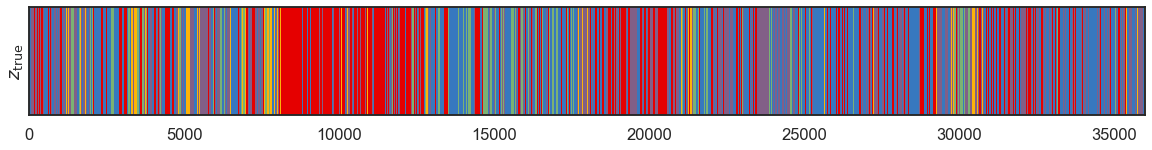

In [177]:
plt.figure(figsize=(20,2))
plt.imshow(z_2[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

In [137]:
arhmm_predict_x_2 = arhmm_k_step_prediction(arhmm_2, z_2, traj29)

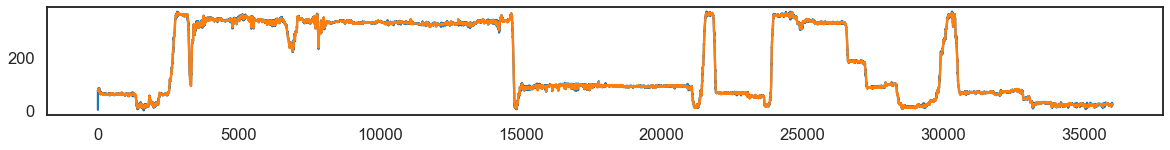

In [138]:
plt.figure(figsize=(20,2))
plt.plot(arhmm_predict_x_2[:,3])
plt.plot(traj29[:,3])

In [139]:
arhmm_sample_z_2, arhmm_sample_x_2 = arhmm_2.sample(T)

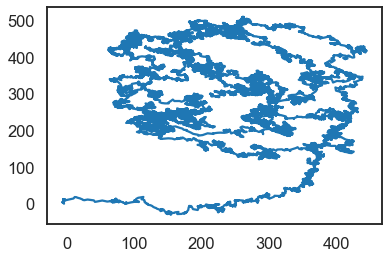

In [140]:
plt.plot(arhmm_sample_x_2[:,0], arhmm_sample_x_2[:,1])

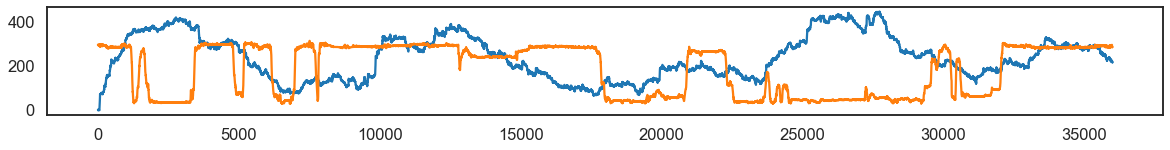

In [182]:
plt.figure(figsize=(20,2))
plt.plot(arhmm_sample_x_2[:,0])
plt.plot(traj29[:,0])

conjecture:

- the reason why arhmm can learn smooth speed transition, it is because the model is tranined to "completion"
- the state is fast switching

I'm going to dive into the behaviors close to the wall.

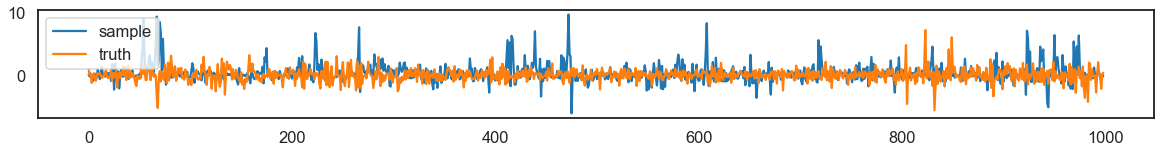

In [151]:
plt.figure(figsize=(20,2))
plt.plot(np.diff(arhmm_sample_x_2[:1000,0]), label='sample')
plt.plot(np.diff(traj29[:1000,0]), label='truth')
plt.legend()

reflection in pytorch implementation:

- adam method seems to be converging slower
- maybe convergence is the reaspm why logistic normal is not performing well

two direction:
    - write logistic normal in ssm (gonna try)
    - dig into pytorch optimization issue

